Based on https://github.com/TeconomicsBlog/notebooks/blob/master/PrincipledInstrumentSelection.ipynb

In [2]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import itertools
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
import copy
random.seed(10)

In [3]:
N = 1000
tau = 2
weak = np.random.normal(0,1,[N,1])
good = np.random.normal(0,1,[N,1])
correl = np.random.normal(0,1,[N,1])
C = 3*correl + np.random.normal(0,1,[N,1])
X = -.000001 * np.round(weak) + 2.5 * correl + 2.5 * good + .5 * C + np.random.normal(0,1,[N,1])
Y = tau * X + 1.1 * C + np.random.normal(0,1,[N,1])
df = pd.DataFrame({'Y':Y[:,0],'X':X[:,0],'correl':correl[:,0],'good':good[:,0],'weak':weak[:,0]},index = None)

In [4]:
df.head()

,Y,X,correl,good,weak
0,-12.826713,-4.458227,-1.340288,0.551037,0.219079
1,3.456734,-0.292264,0.891619,-1.609383,1.091374
2,3.309675,0.446748,0.457430,-0.371955,0.499583
3,-26.736045,-9.940684,-2.078578,-0.908508,0.253724
4,-5.054177,-2.303376,-0.104756,-0.262771,1.078833


### Naive regression without an instrument

In [5]:
mod = sm.OLS(Y,X)
res = mod.fit()
print(res.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                          2.910e+04
Date:                Fri, 05 Feb 2021   Prob (F-statistic):                        0.00
Time:                        10:24:45   Log-Likelihood:                         -2257.3
No. Observations:                1000   AIC:                                      4517.
Df Residuals:                     999   BIC:                                      4522.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [6]:
estDict = {} # store estimates
estDict['no_instrument'] = (float(res.params),float(res.HC0_se))

We can also use the IV2SLS estimator with no instruments

In [7]:
ivmod = IV2SLS(df.Y, exog = df.X, endog = None, instruments = None)
res_2sls = ivmod.fit()
print(res_2sls.summary)

                            OLS Estimation Summary                            
Dep. Variable:                      Y   R-squared:                      0.9668
Estimator:                        OLS   Adj. R-squared:                 0.9668
No. Observations:                1000   F-statistic:                 2.633e+04
Date:                Fri, Feb 05 2021   P-value (F-stat)                0.0000
Time:                        10:24:46   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X              2.5568     0.0158     162.26     0.0000      2.5260      2.5877


/Users/ida/opt/anaconda3/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


### Fit using a good instrument (strong first stage and satisfies exclusion restriction)

In [8]:
ivmod = IV2SLS(df.Y, exog = None, endog = df.X, instruments = df.good)
res_2sls = ivmod.fit()
estDict['good_instrument'] = (float(res_2sls.params),float(res_2sls.std_errors))
print(res_2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                      0.9261
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9260
No. Observations:                1000   F-statistic:                    2662.3
Date:                Fri, Feb 05 2021   P-value (F-stat)                0.0000
Time:                        10:24:47   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X              2.0319     0.0394     51.597     0.0000      1.9548      2.1091

Endogenous: X
Instruments: good
Robust Covariance (

### Fit using a weak instrument (satisfies exclusion restriction)

In [9]:
ivmod = IV2SLS(df.Y, exog = None, endog = df.X, instruments = df.weak)
res_2sls = ivmod.fit()
estDict['weak_instrument'] = (float(res_2sls.params),float(res_2sls.std_errors))
print(res_2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                     -0.5023
Estimator:                    IV-2SLS   Adj. R-squared:                -0.5038
No. Observations:                1000   F-statistic:                 1.852e-05
Date:                Fri, Feb 05 2021   P-value (F-stat)                0.9966
Time:                        10:24:55   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X             -0.5950     138.24    -0.0043     0.9966     -271.55      270.36

Endogenous: X
Instruments: weak
Robust Covariance (

### Fit using an instrument that doesn't satisfy the exclusion restriction (but with a strong first stage)

In [10]:
ivmod = IV2SLS(df.Y, exog = None, endog = df.X, instruments = df.correl)
res_2sls = ivmod.fit()
estDict['failed_excl'] = (float(res_2sls.params),float(res_2sls.std_errors))
print(res_2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                      0.9575
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9574
No. Observations:                1000   F-statistic:                 1.786e+04
Date:                Fri, Feb 05 2021   P-value (F-stat)                0.0000
Time:                        10:24:56   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X              2.8084     0.0210     133.63     0.0000      2.7673      2.8496

Endogenous: X
Instruments: correl
Robust Covariance

In [11]:
estimates = [tau] + list(i[0] for i in estDict.values())
bnds = [0] + list(1.96*i[1] for i in estDict.values())
x_pos = np.arange(len(estimates))
labels = ['true']+list(estDict.keys())

In [13]:
estimates

[2, 2.556847752026293, 2.031947871148329, -0.5949620203795, 2.8084476158295746]

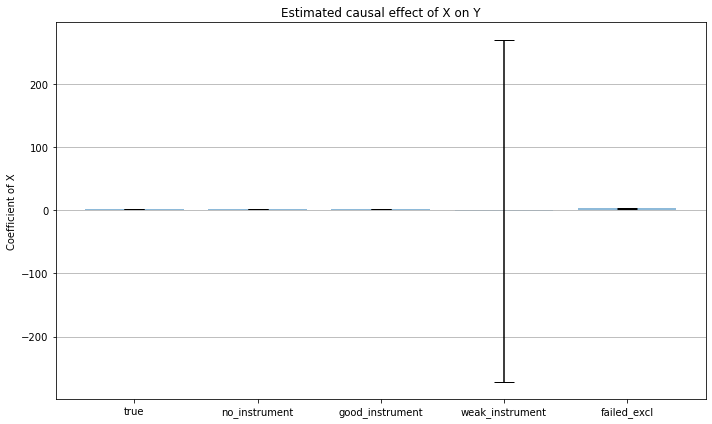

In [12]:
fig, ax = plt.subplots(figsize = (10,6))
ax.bar(x_pos, estimates, yerr=bnds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Coefficient of X')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Estimated causal effect of X on Y')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()